In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train=pd.read_csv("Training_set.csv")

In [3]:
train=train.sample(train.shape[0])

In [4]:
test=pd.read_csv("Test_set.csv")

In [5]:
test.shape

(294, 27)

In [6]:
def get_job_characteristics(df): 
    job_type=[]
    job_title=[]
    employer_title=[]
    employer_sector_title=[]
    job_sector_title=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        types=data["job_type"]
        title=data["job_title"]
        em_title=data["employer_title"]
        em_sec_title=data["employer_sector_title"]
        job_sec_title=data["job_sector_title"]
        job_type.append(types)
        job_title.append(title)
        employer_title.append(em_title)
        employer_sector_title.append(em_sec_title)
        job_sector_title.append(job_sec_title)
    d={}
    #d["job_title"]=job_title
    #d["employer_title"]=employer_title
    d["employer_sector_title"]=employer_sector_title
    d["job_sector_title"]=job_sector_title
    a=pd.DataFrame(d)
    data=pd.get_dummies(a)
    b=pd.get_dummies(job_type)
    result = pd.concat([data, b], axis=1, sort=False)
    return result

In [7]:
def get_data_for_user(user):
    jobtitles=list(user["job_title"].values)
    emtitles=list(user["employer_title"].values)
    jobsectitles=list(user["job_sector_title"].values)
    emsectitles=list(user["employer_sector_title"].values)
    a=""
    for k in range(len(jobtitles)):
        a+=jobtitles[k]+" "
        a+=emtitles[k]+" "
        a+=jobsectitles[k]+" "
        #a+=emsectitles[k]+" "
    return a

In [8]:
def get_user_characteristics(df):
    corpus=[]
    gender=[]
    ethnicity=[]
    school_type=[]
    right_to_work_uk=[]
    university_name=[]
    university_type=[]
    course_includes_industrial_placement=[]
    degree_subject_name=[]
    user_preference=[]
    job_types=list(set(df["job_type"].values))
    em_sectors=list(set(df["employer_sector_title"].values))
    job_sectors=list(set(df["job_sector_title"].values))
    count_job_types=[[] for i in range(len(job_types))]
    count_job_sectors=[[] for i in range(len(job_sectors))]
    count_em_sectors=[[] for i in range(len(em_sectors))]
    nb_em_sector=[]
    nb_job_sector=[]
    job_type=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        user=data["user_id"]
        user_data=df[df["user_id"]==user]
        user_job_type=dict(Counter(list(user_data["job_type"].values)))
        user_job_sectors=dict(Counter(list(user_data["job_sector_title"].values)))
        user_em_sectors=dict(Counter(list(user_data["employer_sector_title"].values)))
        user_em_sector=len(list(set(list(user_data["employer_sector_title"].values))))
        user_job_sector=len(list(set(list(user_data["job_sector_title"].values))))
        for i in range(len(count_job_types)):
            try:
                count_job_types[i].append(user_job_type[i])
            except:
                count_job_types[i].append(0)
        for i in range(len(count_job_sectors)):
            try:
                count_job_sectors[i].append(user_job_sectors[i])
            except:
                count_job_sectors[i].append(0)
        for i in range(len(count_em_sectors)):
            try:
                count_em_sectors[i].append(user_em_sectors[i])
            except:
                count_em_sectors[i].append(0)
        sex=data["gender"]
        jobtype=data["job_type"]
        eth=data["ethnicity"]
        school=data["school_type"]
        placement=data["course_includes_industrial_placement"]
        right=data["right_to_work_uk"]
        uni=data["university_name"]
        uni_type=data["university_type"]
        subname=data["degree_subject_name"]
        pref=data["user_preference"]
        title=data["job_title"]
        em_title=data["employer_title"]
        em_sec_title=data["employer_sector_title"]
        job_sec_title=data["job_sector_title"]
        if sex=="F":
            sex="Female"
        elif sex=="M":
            sex="Male"
        if placement==True:
            placement=1
        elif placement==False:
            placement=-1
        else:
            placement=0
        if right==True:
            right=1
        elif right==False:
            right=-1
        else:
            right=0
        if type(pref) is float:
            pref=""
        if type(subname) is float:
            subname=""
        nb_em_sector.append(user_em_sector)
        nb_job_sector.append(user_job_sector)
        gender.append(sex)
        ethnicity.append(eth)
        school_type.append(school)
        course_includes_industrial_placement.append(placement)
        right_to_work_uk.append(right)
        university_type.append(uni_type)
        #degree_subject_name.append(subname)
        #user_preference.append(pref)
        job_type.append(jobtype)
        corpus.append(pref+subname+" "+get_data_for_user(user_data))
    d={}
    for i in range(len(count_job_sectors)):
        d['count_job_sectors_'+str(i)]=count_job_sectors[i]
    for i in range(len(count_em_sectors)):
        d['count_em_sectors_'+str(i)]=count_em_sectors[i]
    for i in range(len(count_job_types)):
        d['count_job_types_'+str(i)]=count_job_types[i]
    d["gender"]=gender
    d["job_type"]=job_type
    d["nb_em_sector"]=nb_em_sector
    d["nb_job_sector"]=nb_job_sector
    d["right_to_work_uk"]=right_to_work_uk
    d["ethnicity"]=ethnicity
    #d["degree_subject_name"]=degree_subject_name
    d["school_type"]=school_type
    #d["user_preference"]=user_preference
    d["course_includes_industrial_placement"]=course_includes_industrial_placement
    a=pd.DataFrame(d)
    data=pd.get_dummies(a)
    b=pd.get_dummies(university_type)
    result = pd.concat([data, b], axis=1, sort=False)
    vectorizer = CountVectorizer(max_df=1.0, min_df=3)
    X = vectorizer.fit_transform(corpus)
    col=vectorizer.get_feature_names()
    donnees=X.toarray()
    print(X.shape)
    donnee=pd.DataFrame(donnees, columns=col)
    final=pd.concat([result, donnee], axis=1)
    return final

In [9]:
#user_characteristics=get_user_characteristics(train)

In [10]:
#user_characteristics.shape

In [11]:
#job_characteristics=get_job_characteristics(train)

In [12]:
#job_characteristics.shape

In [14]:
def get_user_info(df):
    user_info=[]
    d={}
    x=train[["user_id","job_title","employer_title","job_sector_title","job_description",
             "employer_sector_title","employer_description"]]
    n=df.shape[0]
    for i in range(n):
        if i%5000==0:
            print("progress: ",i/n)
        data=df.iloc[i]
        user_id=data["user_id"]
        try:
            a=d[str(user_id)]
        except:
            y=x[x["user_id"]==user_id]
            if y.shape[0]>0:
                job_titles=y["job_title"].values
                job_sector_title=y["job_sector_title"].values
                description=y["job_description"].values
                em_titles=y["employer_title"].values
                em_sector_title=y["employer_sector_title"].values
                em_description=y["employer_description"].values
                university_name=data["university_name"]
                degree_subject_name=data["degree_subject_name"]
                user_preference=data["user_preference"]
                ethnicity=data["ethnicity"]
                school_type=data["school_type"]
                if type(user_preference) is float:
                    user_preference=""
                if type(university_name) is float:
                    university_name=""
                if type(degree_subject_name) is float:
                    degree_subject_name=""
                if type(ethnicity) is float:
                    ethnicity=""
                if type(school_type) is float:
                    school_type=""
                try:
                    if np.isnan(user_preference):
                        user_preference=""
                except:
                    pass
                try:
                    if np.isnan(university_name):
                        university_name=""
                except:
                    pass
                try:
                    if np.isnan(degree_subject_name):
                        degree_subject_name=""
                except:
                    pass
                try:
                    if np.isnan(ethnicity):
                        ethnicity=""
                except:
                    pass
                try:
                    if np.isnan(school_type):
                        school_type=""
                except:
                    pass
                user_preference=user_preference+" "
                user_preference=user_preference *3
                degree_subject_name=degree_subject_name+" "
                degree_subject_name=degree_subject_name *3
                a=""
                a+=university_name+" "
                a+=degree_subject_name+" "
                a+=user_preference+" "
                a+=ethnicity+" "
                a+=school_type+" "
                for k in range(len(job_titles)):
                    a+=job_titles[k]+" "
                    a+=job_sector_title[k]+" "
                    a+=description[k]+" "
                    a+=em_titles[k]+" "
                    a+=em_sector_title[k]+" "
                    a+=em_description[k]+" "
                a=a.replace("Graduate","").replace("Programme","").replace("  "," ").replace("&","")
            else:
                university_name=data["university_name"]
                degree_subject_name=data["degree_subject_name"]
                user_preference=data["user_preference"]
                ethnicity=data["ethnicity"]
                school_type=data["school_type"]
                if type(user_preference) is float:
                    user_preference=""
                if type(university_name) is float:
                    university_name=""
                if type(degree_subject_name) is float:
                    degree_subject_name=""
                if type(ethnicity) is float:
                    ethnicity=""
                if type(school_type) is float:
                    school_type=""
                try:
                    if np.isnan(user_preference):
                        user_preference=""
                except:
                    pass
                try:
                    if np.isnan(university_name):
                        university_name=""
                except:
                    pass
                try:
                    if np.isnan(degree_subject_name):
                        degree_subject_name=""
                except:
                    pass
                try:
                    if np.isnan(ethnicity):
                        ethnicity=""
                except:
                    pass
                try:
                    if np.isnan(school_type):
                        school_type=""
                except:
                    pass
                user_preference=user_preference+" "
                user_preference=user_preference *3
                degree_subject_name=degree_subject_name+" "
                degree_subject_name=degree_subject_name *3
                a=""
                a+=university_name+" "
                a+=degree_subject_name+" "
                a+=user_preference+" "
                a+=ethnicity+" "
                a+=school_type+" "
            d[str(user_id)]=a
        user_info.append(a)
    return user_info

In [15]:
test_user_info=get_user_info(test)

progress:  0.0


In [16]:
train_user_info=get_user_info(train)

progress:  0.0
progress:  0.03995652729829945
progress:  0.0799130545965989
progress:  0.11986958189489835
progress:  0.1598261091931978
progress:  0.19978263649149725
progress:  0.2397391637897967
progress:  0.27969569108809617
progress:  0.3196522183863956
progress:  0.35960874568469503
progress:  0.3995652729829945
progress:  0.43952180028129395
progress:  0.4794783275795934
progress:  0.5194348548778929
progress:  0.5593913821761923
progress:  0.5993479094744918
progress:  0.6393044367727913
progress:  0.6792609640710906
progress:  0.7192174913693901
progress:  0.7591740186676895
progress:  0.799130545965989
progress:  0.8390870732642884
progress:  0.8790436005625879
progress:  0.9190001278608874
progress:  0.9589566551591868
progress:  0.9989131824574863


In [17]:
len(train_user_info)

125136

In [18]:
len(test_user_info)

294

In [19]:
def clean_user(x,df):
    n=len(x)
    res=[]
    d={}
    for i,content in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        user_id=data["user_id"]
        try:
            y=d[str(user_id)]
        except:
            content=content.replace(",","").replace("-"," ").replace("  "," ").replace("&eacute;","e")
            content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
            content=content.replace("&bull;","\r\n ").replace("bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
            content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
            content=content.replace("&eacute;","e").replace("&lsquo;","").replace("lsquo;","").replace("&#39;","").replace("#39;s","")
            content=content.replace("&nbsp;"," ").replace("nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
            content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ").replace("middot;","")
            content=content.replace("&rsquo;","").replace("rsquo;"," ").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
            content=content.replace("&ndash;"," ").replace("ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
            content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
            content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
            content=re.sub('<.*?>',"",content , flags=re.DOTALL)
            content=content.replace("&ldquo;","").replace("ldquo;","").replace("&rdquo;","").replace("rdquo;","")
            try:
                content=''.join([i for i in content if not i.isdigit()])
            except:
                pass
            content=content.split(" ")
            y=[]
            for i in content:
                if len(i)>1:
                    y.append(i.lower())
            d[str(user_id)]=y
        res.append(y)
    return res

In [20]:
clean_test_user_info=clean_user(test_user_info, test)

progress :  0.0


In [21]:
clean_train_user_info=clean_user(train_user_info, train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [22]:
def get_job_info(df):
    job_info=[]
    d={}
    for i in range(df.shape[0]):
        data=df.iloc[i]
        job_id=data["job_id"]
        try:
            a=d[str(job_id)]
        except:
            title=data["job_title"]
            job_sector_title=data["job_sector_title"]
            description=data["job_description"]
            em_title=data["employer_title"]
            em_sector_title=data["employer_sector_title"]
            em_description=data["employer_description"]
            a=""
            a+=title+" "
            a+=job_sector_title+" "
            a+=description+" "
            a+=em_title+" "
            a+=em_sector_title+" "
            a+=em_description
            d[str(job_id)]=a
        job_info.append(a)
    return job_info

In [23]:
test_job_info=get_job_info(test)

In [24]:
train_job_info=get_job_info(train)

In [25]:
def clean(x,df):
    res=[]
    n=len(x)
    d={}
    for i,content in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        job_id=data["job_id"]
        try:
            y=d[str(job_id)]
        except:
            content=content.replace(",","").replace("-"," ").replace("  "," ").replace("&eacute;","e")
            content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
            content=content.replace("&bull;","\r\n ").replace("bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
            content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
            content=content.replace("&eacute;","e").replace("&lsquo;","").replace("lsquo;","").replace("&#39;","").replace("#39;s","")
            content=content.replace("&nbsp;"," ").replace("nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
            content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ").replace("middot;","")
            content=content.replace("&rsquo;","").replace("rsquo;"," ").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
            content=content.replace("&ndash;"," ").replace("ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
            content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
            content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
            content=re.sub('<.*?>',"",content , flags=re.DOTALL)
            content=content.replace("&ldquo;","").replace("ldquo;","").replace("&rdquo;","").replace("rdquo;","")
            try:
                content=''.join([i for i in content if not i.isdigit()])
            except:
                pass
            content=content.split(" ")
            y=[]
            for i in content:
                if len(i)>1:
                    y.append(i.lower())
            d[str(job_id)]=y
        res.append(y)
    return res

In [26]:
cleaned_test_job_info=clean(test_job_info,test)

progress :  0.0


In [27]:
cleaned_train_job_info=clean(train_job_info,train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [28]:
def remove_stopwords_job(x, df):
    res=[]
    n=len(x)
    d={}
    with open('stopwords.txt') as stopfile:
        stopwords = stopfile.read()
        stop = stopwords.split()
    for i,job in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        job_id=data["job_id"]
        try:
            a=d[str(job_id)]
        except:
            a=[]
            for word in job:
                if word not in stop:
                    a.append(word)
            d[str(job_id)]=a
        res.append(a)
    return res

In [29]:
def remove_stopwords_user(x, df):
    res=[]
    n=len(x)
    d={}
    with open('stopwords.txt') as stopfile:
        stopwords = stopfile.read()
        stop = stopwords.split()
    for i,user in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        user_id=data["user_id"]
        try:
            a=d[str(user_id)]
        except:
            a=[]
            for word in user:
                if word not in stop:
                    a.append(word)
            d[str(user_id)]=a
        res.append(a)
    return res

In [30]:
test_clean=remove_stopwords_job(cleaned_test_job_info,test)

progress :  0.0


In [31]:
train_clean=remove_stopwords_job(cleaned_train_job_info,train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [32]:
test_user_clean=remove_stopwords_user(clean_test_user_info,test)

progress :  0.0


In [33]:
train_user_clean=remove_stopwords_user(clean_train_user_info,train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [34]:
def get_occurence_job(x,df):
    res=[]
    n=len(x)
    d={}
    for i,job in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        job_id=data["job_id"]
        try:
            a=d[str(job_id)]
        except:
            a=dict(Counter(job))
            d[str(job_id)]=a
        res.append(a)
    return res

In [35]:
def get_occurence_user(x,df):
    res=[]
    n=len(x)
    d={}
    for i,user in enumerate(x):
        if i%5000==0:
            print("progress : ",i/n)
        data=df.iloc[i]
        user_id=data["user_id"]
        try:
            a=d[str(user_id)]
        except:
            a=dict(Counter(user))
            d[str(user_id)]=a
        res.append(a)
    return res

In [36]:
test_occurences=get_occurence_job(test_clean,test)

progress :  0.0


In [37]:
occurences=get_occurence_job(train_clean,train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [38]:
test_user_occurences=get_occurence_user(test_user_clean,test)

progress :  0.0


In [39]:
train_user_occurences=get_occurence_user(train_user_clean,train)

progress :  0.0
progress :  0.03995652729829945
progress :  0.0799130545965989
progress :  0.11986958189489835
progress :  0.1598261091931978
progress :  0.19978263649149725
progress :  0.2397391637897967
progress :  0.27969569108809617
progress :  0.3196522183863956
progress :  0.35960874568469503
progress :  0.3995652729829945
progress :  0.43952180028129395
progress :  0.4794783275795934
progress :  0.5194348548778929
progress :  0.5593913821761923
progress :  0.5993479094744918
progress :  0.6393044367727913
progress :  0.6792609640710906
progress :  0.7192174913693901
progress :  0.7591740186676895
progress :  0.799130545965989
progress :  0.8390870732642884
progress :  0.8790436005625879
progress :  0.9190001278608874
progress :  0.9589566551591868
progress :  0.9989131824574863


In [40]:
def get_vector_job(occurences, jobs, vector_size,df):
    vector=[]
    d={}
    model = Word2Vec.load('model.bin')
    nb=len(jobs)
    for i,job in enumerate(jobs):
        if i%10000==0:
            print("progress : ",i/nb )
        data=df.iloc[i]
        job_id=data["job_id"]
        try:
            res=d[str(job_id)]
        except:
            res=np.zeros(vector_size,)
            n=sum(list(occurences[i].values()))
            job_unique=list(set(job))
            for word in job_unique:
                try:
                    a=model[word]
                except:
                    #print(word)
                    a=None
                if a is not None:
                    count=occurences[i][word]
                    w=count/n
                    res+=w*a
            d[str(job_id)]=res
        vector.append(res)
    return vector

In [41]:
def get_vector_user(occurences, users, vector_size,df):
    vector=[]
    d={}
    model = Word2Vec.load('model.bin')
    nb=len(users)
    for i,user in enumerate(users):
        if i%10000==0:
            print("progress : ",i/nb )
        data=df.iloc[i]
        user_id=data["user_id"]
        try:
            res=d[str(user_id)]
        except:
            res=np.zeros(vector_size,)
            n=sum(list(occurences[i].values()))
            user_unique=list(set(user))
            for word in user_unique:
                try:
                    a=model[word]
                except:
                    #print(word)
                    a=None
                if a is not None:
                    count=occurences[i][word]
                    w=count/n
                    res+=w*a
            d[str(user_id)]=res
        vector.append(res)
    return vector

In [42]:
test_X=get_vector_job(test_occurences, test_clean, 350,test)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [43]:
X=get_vector_job(occurences, train_clean, 350,train)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


progress :  0.0799130545965989
progress :  0.1598261091931978
progress :  0.2397391637897967
progress :  0.3196522183863956
progress :  0.3995652729829945
progress :  0.4794783275795934
progress :  0.5593913821761923
progress :  0.6393044367727913
progress :  0.7192174913693901
progress :  0.799130545965989
progress :  0.8790436005625879
progress :  0.9589566551591868


In [44]:
test_X_user=get_vector_user(test_user_occurences, test_user_clean, 350, test)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [45]:
X_user=get_vector_user(train_user_occurences, train_user_clean, 350, train)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


progress :  0.0799130545965989
progress :  0.1598261091931978
progress :  0.2397391637897967
progress :  0.3196522183863956
progress :  0.3995652729829945
progress :  0.4794783275795934
progress :  0.5593913821761923
progress :  0.6393044367727913
progress :  0.7192174913693901
progress :  0.799130545965989
progress :  0.8790436005625879
progress :  0.9589566551591868


In [46]:
test_X_train=np.array(test_X)

In [52]:
test_X_train.shape

(294, 350)

In [47]:
X_train=np.array(X)

In [48]:
X_train.shape

(125136, 350)

In [49]:
test_X_train_user=np.array(test_X_user)

In [50]:
X_train_user=np.array(X_user)

In [51]:
X_train_user.shape

(125136, 350)

In [37]:
#X_train_job_final=np.concatenate((X_train, job_characteristics.values), axis=1)

In [38]:
#X_train_job_final.shape

In [39]:
#X_train_user_final=np.concatenate((X_train_user, user_characteristics.values), axis=1)

In [40]:
#X_train_user_final.shape

In [41]:
#pca = PCA(n_components=2)
#result_user = pca.fit_transform(X_train_user_final)

In [42]:
#print(pca.explained_variance_ratio_)

In [43]:
#pca = PCA(n_components=2)
#result = pca.fit_transform(X_train_job_final)

In [44]:
#print(pca.explained_variance_ratio_)

In [45]:
#users=list(train["user_id"].values)
#users=[str(i) for i in users]

In [46]:
def get_job_info_plot(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        em_title=data["employer_title"]
        a=""
        a+=title+" "
        a+=em_title+" "
        job_info.append(a)
    return job_info

In [47]:
#infos=get_job_info_plot(train)

In [48]:
"""k=200
plt.figure(figsize=(20,20))
plt.scatter(result_user[:k, 0], result_user[:k, 1])
for i, word in enumerate(users[:k]):
    plt.annotate(word, xy=(result_user[i, 0], result_user[i, 1]))
plt.show()"""

'k=200\nplt.figure(figsize=(20,20))\nplt.scatter(result_user[:k, 0], result_user[:k, 1])\nfor i, word in enumerate(users[:k]):\n    plt.annotate(word, xy=(result_user[i, 0], result_user[i, 1]))\nplt.show()'

In [49]:
train.iloc[10][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']]

job_title                2018 London Summer Internship: Analytics and S...
employer_title                                                   Bloomberg
employer_sector_title                                   Financial Services
job_sector_title                                        Financial Services
gender                                                                Male
ethnicity                                              White/White British
university_name                                        McMaster University
degree_subject_name                                   Accounting & Finance
user_preference          Investment Banking Investment & Asset Manageme...
Name: 77245, dtype: object

In [54]:
def get_similar_member(df, X_train, doc_id, n):
    res=[]
    beta=[]
    cos=list(cosine_similarity(X_train[doc_id,:].reshape(1, -1) , X_train))[0]
    most_similar_doc_id=np.argsort(cos)[::-1]
    a=0
    while cos[most_similar_doc_id[a]]>=0.9999999:
        a+=1
    most_similar_doc_id=most_similar_doc_id[a:]
    res.append(df.iloc[most_similar_doc_id[0]]["user_id"])
    beta.append(cos[most_similar_doc_id[0]])
    for i in range(1,len(most_similar_doc_id)):
        if cos[most_similar_doc_id[i]] not in beta:
            user=df.iloc[most_similar_doc_id[i]]["user_id"]
            if user not in res:
                res.append(user)
                beta.append(cos[most_similar_doc_id[i]])
    print(" user id : ", df.iloc[doc_id]["user_id"])
    print("most similar doc : ", res[:n])
    print("most similar values : ", beta[:n])
    print("not similar doc : ", res[-n:][::-1])
    print("not similar values : ", beta[-n:][::-1])

In [55]:
get_similar_member(train, X_train_user, 10, 5)

 user id :  117634
most similar doc :  [182869, 155182, 146277, 52700, 153157]
most similar values :  [0.975068524594033, 0.9739203089866663, 0.9697470865692897, 0.9697416553711267, 0.9690428114453487]
not similar doc :  [158698, 180714, 173617, 186064, 186752]
not similar values :  [-0.07001069043253998, -0.06287017174375545, 0.14585444441232004, 0.15957284873485147, 0.16721659155234422]


# user

In [56]:
train[train["user_id"]==117634][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail()

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
62435,2018 Associate Programme,On Purpose,Entrepreneurship & Start Ups,Charity & Social Enterprise,Female,White/White British,Royal Holloway,Sociology,NaN
62433,Graduate Scheme,Worthwhile,Entrepreneurship & Start Ups,Charity & Social Enterprise,Female,White/White British,Royal Holloway,Sociology,NaN
62437,2018 Corporate Analyst Development Program - F...,J.P. Morgan,Financial Services,Financial Services,Female,White/White British,Royal Holloway,Sociology,NaN
62432,Commercial programme,BAE Systems,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,White/White British,Royal Holloway,Sociology,NaN
62431,Global Research Global Graduate Programme,HSBC,Financial Services,Financial Services,Female,White/White British,Royal Holloway,Sociology,NaN


# similar users

In [57]:
train[train["user_id"]==182869][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail()

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
60913,2018 Associate Programme,On Purpose,Entrepreneurship & Start Ups,Charity & Social Enterprise,Female,NaN,NaN,NaN,Entrepreneurship & Start Ups Journalism & Publ...
60914,Graduate Programme,HM Treasury,Public Sector & Government,Financial Services,Female,NaN,NaN,NaN,Entrepreneurship & Start Ups Journalism & Publ...
60911,Global Research Global Graduate Programme,HSBC,Financial Services,Financial Services,Female,NaN,NaN,NaN,Entrepreneurship & Start Ups Journalism & Publ...
60919,Deutsche Bank Graduate Programme,Deutsche Bank,Technology: Consulting & Project Management,Technology: Consulting & Project Management,Female,NaN,NaN,NaN,Entrepreneurship & Start Ups Journalism & Publ...
60918,Graduate Analyst Role,CIL Management Consultants,Consulting,Consulting,Female,NaN,NaN,NaN,Entrepreneurship & Start Ups Journalism & Publ...


In [58]:
train[train["user_id"]==155182][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail()

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
91995,International Company - Graduate,Robert Half,HR & Recruitment,Financial Services,Female,White/White British,University of Exeter,Modern Languages,NaN
92003,Community Banking Leadership Programme,Lloyds Banking Group,Financial Services,Financial Services,Female,White/White British,University of Exeter,Modern Languages,NaN
91993,Graduate Teacher Training Programme,Ark Teacher Training,Education & Teaching,Charity & Social Enterprise,Female,White/White British,University of Exeter,Modern Languages,NaN
91994,Leadership Development Programme,Teach First,Education & Teaching,Charity & Social Enterprise,Female,White/White British,University of Exeter,Modern Languages,NaN
92006,Graduate Scheme,Brainlabs,Education & Teaching,Technology: IT & Software Development,Female,White/White British,University of Exeter,Modern Languages,NaN


# not similar users

In [59]:
train[train["user_id"]==158698][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
106992,Herbert Smith Freehills Event Dates 2017-2018,Herbert Smith Freehills,Commercial Law,Commercial Law,Male,Asian/Asian British,University of Warwick,Engineering - Mechanical,Commercial Law


In [60]:
train[train["user_id"]==186752][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
81558,Internship - Equity Markets and Commodities - ...,Commerzbank AG,Financial Services,Financial Services,Female,NaN,NaN,NaN,NaN


In [58]:
train[train["user_id"]==98253][['job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].tail(7)

,job_title,employer_title,employer_sector_title,job_sector_title,gender,ethnicity,university_name,degree_subject_name,user_preference
125035,Campus Ambassadors,Reed Smith,Commercial Law,Commercial Law,Female,NaN,Durham University,History and Spanish,Commercial Law


In [59]:
def get_similar_doc(X_train, doc_id, n):
    res=[]
    beta=[]
    cos=list(cosine_similarity(X_train[doc_id,:].reshape(1, -1) , X_train))[0]
    most_similar_doc_id=np.argsort(cos)[::-1]
    a=0
    while cos[most_similar_doc_id[a]]>=0.9999999:
        a+=1
    most_similar_doc_id=most_similar_doc_id[a:]
    res.append(most_similar_doc_id[0])
    beta.append(cos[most_similar_doc_id[0]])
    for i in range(1,len(most_similar_doc_id)):
        if cos[most_similar_doc_id[i]] not in beta:
            res.append(most_similar_doc_id[i])
            beta.append(cos[most_similar_doc_id[i]])
    print("most similar doc : ", res[:n])
    print("most similar values : ", beta[:n])
    print("not similar doc : ", res[-n:][::-1])
    print("not similar values : ", beta[-n:][::-1])

In [60]:
def clean_similarity(x):
    res=[] 
    for content in x:
        content=content.replace(",","").replace("-"," ").replace("  "," ")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=content.replace("&bull;","\r\n ").replace("bull;","\r\n ").replace("\r\r\n\t"," ").replace("\r\r\n"," ")
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("lsquo;","").replace("&#39;","").replace("#39;s","")
        content=content.replace("&nbsp;"," ").replace("nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ").replace("middot;","")
        content=content.replace("&rsquo;","").replace("rsquo;"," ").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        res.append(content)
    return res

In [61]:
data_similarity=clean_similarity(train_job_info)

In [62]:
get_similar_doc(X_train, 10, 5)

most similar doc :  [4803, 100129, 19504, 87946, 15489]
most similar values :  [0.9321410823965482, 0.877775035714811, 0.8549871440947936, 0.8545249908564095, 0.85361269657517]
not similar doc :  [28126, 92617, 23967, 2469, 103972]
not similar values :  [-0.192487014464302, -0.04588360545967207, 0.04989405810715601, 0.08692438747711734, 0.10738647218471054]


# job

In [63]:
data_similarity[10]

'Internship Consulting What do you want to be famous for  New consultants at Oliver Wyman get greater client and global opportunities and develop unique expertise sooner than their peers at other consulting firms  Specialized expertise enables you to own an area of our business early on and create more impact for our clients Some clients still hire generalist management consultancies for what they think Oliver Wyman clients hire us for what we know  Interns get real responsibility here Internships at Oliver Wyman provide a true taste of life as a consultant and unique preparation for a full time role Youll be staffed on projects and treated like full team members with responsibility for a distinct piece of work Coaching and feedback is provided throughout your time with usWe consider candidates in their penultimate year of university study Most join during the summer or a winter term In some European countries we offer internships throughout the year  Our internship program will give y

# Similar jobs

In [64]:
data_similarity[69307]

'Graduate programme Media Film & TV Not that we like to blow our own trumpet but there a good argument to suggest that our graduate training scheme is the best of all London agencies Our seven week full time scheme covers strategy creative and production in all communications disciplines culminating in a client pitch Then you start work on your accounts  To help you settle in we will set you up with a buddy a grad who went through it all last year a mentor a wise old sage from up the ladder and creative godparents a pair of inspirational wings to be taken under who will stay with you as your career develops Were a big fan of the IPA professional development scheme so youll start with the Foundation Certificate and continue on from there  Both the training and your job will challenge you intellectually and creatively Itll be hard work and therell be late nights at times but we always have lots of fun along the way  We go to as much trouble as possible to make sure that our training is t

# not similar jobs

In [65]:
data_similarity[74064]

'Summer Internship Programs Financial Services Summer Internship Program Our Summer Internship Program is designed to offer real insight into our business The program typically lasts ten weeks and is one of the most in depth internships within the financial services industry From day one youll be part of the team Youll face real challenges have client exposure enjoy real achievements and have your talents recognized every step of the way  Youll be responsible for projects and tasks that matter to the business Youll grow in knowledge skills and confidence Above all youll experience the team spirit that makes Credit Suisse such a special place to work Our program managers will help guide you through your summer experience and each intern is assigned a mentor and a buddy so youll have all the support you need  If you show real potential and demonstrate exceptional performance during your time with us you may be offered a full time position for the following year   Train in a comprehensive

In [61]:
data = np.concatenate((X_train, X_train_user), axis=1)

In [62]:
test_data = np.concatenate((test_X_train, test_X_train_user), axis=1)

In [63]:
test_data.shape

(294, 700)

In [64]:
data.shape

(125136, 700)

# Autoencoder

In [72]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam

In [100]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data[:50000], data[:50000], test_size=0.1)

In [101]:
#test_x_train,test_x_test,test_y_train,test_y_test = train_test_split(test_data, test_data, test_size=0.1)

In [102]:
x_test.shape

(5000, 700)

In [103]:
input_data = Input(shape=(data.shape[1],))
encoded = Dense(600, activation='relu')(input_data)
encoded = Dropout(0.2)(encoded)
encoded = Dense(500, activation='relu')(encoded)
#encoded = Dropout(0.4)(encoded)
encoded = Dense(400, activation='relu')(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(300, activation='relu')(encoded)
#encoded = Dropout(0.4)(encoded)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(100, activation='relu')(encoded)
#encoded = Dropout(0.4)(encoded)
encoded = Dense(50, activation='relu')(encoded)

decoded = Dense(100, activation='relu')(encoded)
#decoded = Dropout(0.4)(decoded)
decoded = Dense(200, activation='relu')(decoded)
decoded = Dropout(0.1)(decoded)
decoded = Dense(300, activation='relu')(decoded)
#decoded = Dropout(0.4)(decoded)
decoded = Dense(400, activation='relu')(decoded)
#decoded = Dropout(0.4)(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(600, activation='relu')(decoded)
#decoded = Dropout(0.4)(decoded)
#decoded = Dense(800, activation='relu')(decoded)
decoded = Dense(data.shape[1], activation='linear')(decoded)

In [104]:
autoencoder = Model(input_data, decoded)
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(loss='mean_squared_error', optimizer=adam)

history=autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=1000,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 66s 1ms/step - loss: 0.0401 - val_loss: 0.0143
Epoch 2/100
45000/45000 [==============================] - 19s 418us/step - loss: 0.0142 - val_loss: 0.0136
Epoch 3/100
45000/45000 [==============================] - 18s 410us/step - loss: 0.0136 - val_loss: 0.0133
Epoch 4/100
45000/45000 [==============================] - 19s 415us/step - loss: 0.0131 - val_loss: 0.0128
Epoch 5/100
45000/45000 [==============================] - 19s 421us/step - loss: 0.0124 - val_loss: 0.0117
Epoch 6/100
45000/45000 [==============================] - 19s 424us/step - loss: 0.0117 - val_loss: 0.0111
Epoch 7/100
45000/45000 [==============================] - 19s 414us/step - loss: 0.0108 - val_loss: 0.0103
Epoch 8/100
45000/45000 [==============================] - 19s 429us/step - loss: 0.0102 - val_loss: 0.0096
Epoch 9/100
45000/45000 [==============================] - 19s 426us/step - loss: 0.0096 

Epoch 76/100
45000/45000 [==============================] - 18s 410us/step - loss: 0.0048 - val_loss: 0.0043
Epoch 77/100
45000/45000 [==============================] - 18s 410us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 78/100
45000/45000 [==============================] - 18s 410us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 79/100
45000/45000 [==============================] - 18s 411us/step - loss: 0.0045 - val_loss: 0.0042
Epoch 80/100
45000/45000 [==============================] - 19s 411us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 81/100
45000/45000 [==============================] - 19s 414us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 82/100
45000/45000 [==============================] - 18s 411us/step - loss: 0.0046 - val_loss: 0.0041
Epoch 83/100
45000/45000 [==============================] - 18s 411us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 84/100
45000/45000 [==============================] - 18s 410us/step - loss: 0.0044 - val_loss: 0.0041
Epoch 85/100
45000/

# Loss

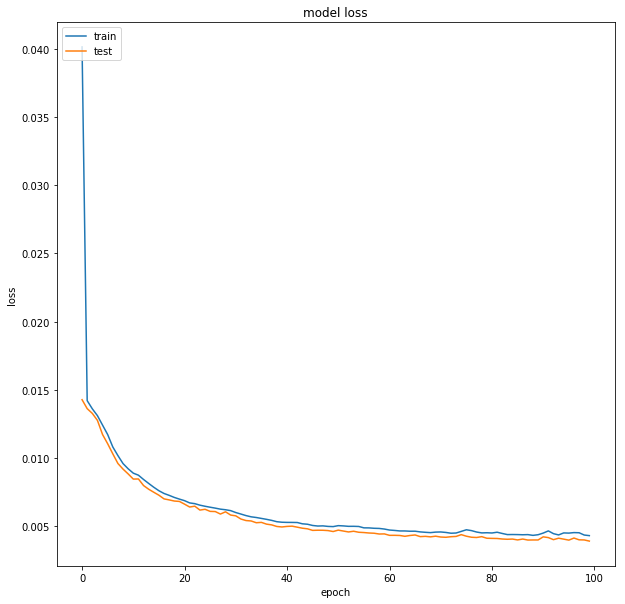

In [105]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [106]:
predictions=autoencoder.predict(x_test)

In [107]:
x_test[0,:50]

array([ 0.13625789, -0.03310135,  0.15258051,  0.18542884, -0.14667562,
       -0.0433409 , -0.0453309 ,  0.46061087,  0.15495482,  0.00464755,
        0.0690035 ,  0.19876439, -0.124733  , -0.49941799,  0.09970417,
       -0.17878871, -0.48727969,  0.25254479, -0.06792465,  0.24076436,
        0.25532069,  0.19164705,  0.12221258, -0.1887714 , -0.42727186,
       -0.1198044 ,  0.29364799,  0.01064422,  0.20107932, -0.59838414,
       -0.05462672, -0.44869577,  0.35362585,  0.06244236, -0.13597924,
        0.08010445, -0.00076955, -0.13958762,  0.01407108, -0.2162974 ,
       -0.06056425, -0.34018136,  0.18150205, -0.06545853,  0.04277986,
        0.18976637,  0.09600769, -0.05285798, -0.06309725,  0.01876783])

In [108]:
predictions[0,:50]

array([ 0.12786062, -0.03806365,  0.13229808,  0.16463894, -0.10416108,
       -0.03818483, -0.07026774,  0.46754682,  0.15315403, -0.03135706,
        0.04248552,  0.18671429, -0.11625774, -0.44280356,  0.09533939,
       -0.15141849, -0.46253166,  0.21592604, -0.07275127,  0.2587865 ,
        0.22713639,  0.19217521,  0.1387617 , -0.13806328, -0.4011377 ,
       -0.14118193,  0.28754392, -0.00486998,  0.18816929, -0.56091994,
       -0.03753273, -0.4206207 ,  0.36410618, -0.00193899, -0.12164011,
        0.05479013,  0.00642793, -0.10858597,  0.01829476, -0.17317158,
       -0.05605114, -0.30355477,  0.16442166, -0.06964883,  0.03091909,
        0.18724237,  0.12358503, -0.06405008, -0.04687829,  0.01483893],
      dtype=float32)

In [109]:
test_predictions=autoencoder.predict(test_data)

In [110]:
test_mse = np.mean(np.power(test_data - test_predictions, 2), axis=1)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)[:test_data.shape[0]]
error_df = pd.DataFrame({'reconstruction_error': mse, 'test_reconstruction_error': test_mse})
error_df.describe()

,reconstruction_error,test_reconstruction_error
count,294.000000,294.000000
mean,0.003817,0.084799
std,0.002902,0.005222
min,0.000447,0.069077
25%,0.001824,0.081146
50%,0.002982,0.084662
75%,0.005151,0.087977
max,0.024716,0.102273


In [111]:
def get_best_worse_jobs(x,n):
    a=np.argsort(x)[:n]
    b=np.argsort(x)[::-1][:n]
    print("best  jobs : ",a)
    print("best  jobs errors : ",x[a])
    print("worst  jobs : ",b)
    print("worst  jobs errors : ",x[b])

In [112]:
get_best_worse_jobs(test_mse,5)

best  jobs :  [252 280  71 142  27]
best  jobs errors :  [0.06907672 0.07427607 0.07468748 0.07492326 0.07532913]
worst  jobs :  [224  69 268  17  36]
worst  jobs errors :  [0.10227323 0.10165618 0.1015958  0.09903719 0.0989834 ]


In [121]:
test.iloc[252][['job_description','job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].values

array(['<h2>Who can apply</h2>\r\r\n\r\r\n<p>This program is suited for students from any academic discipline who are looking to secure a 3-6 month internship as a part of their degree. If you are applying to one of our European offices, you will need to be able to speak the local language.</p>\r\r\n\r\r\n<h2>Application deadline</h2>\r\r\n\r\r\n<p>Applications are accepted year round and reviewed on an ongoing/rolling basis.</p>\r\r\n\r\r\n<h2>About the programme</h2>\r\r\n\r\r\n<p>Off-Cycle Internships typically last between 3-6 months and are available across many of our European offices including: London, Frankfurt, Paris, Zurich, Milan, Geneva, Dubai, Moscow, Madrid, Tel Aviv and Doha. Opportunities are available in the following divisions:&nbsp;</p>\r\r\n\r\r\n<ul>\r\r\n\t<li>Finance</li>\r\r\n\t<li>Global Investment Research</li>\r\r\n\t<li>Investment Banking</li>\r\r\n\t<li>Investment Management</li>\r\r\n\t<li>Securities</li>\r\r\n</ul>\r\r\n\r\r\n<h2>How to apply</h2>\r\r\n\r

In [122]:
test.iloc[280][['job_description','job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].values

array(['<h2>Overview</h2>\r\r\n\r\r\n<p>Alpha Financial Markets Consulting (Alpha FMC) is the leading global consultancy to the asset and wealth management industry. We are a boutique management consulting firm that offers the world&rsquo;s top asset and wealth managers a competitive edge through our unrivalled expertise and industry insight. Our team is of a uniquely high calibre and by focusing on asset and wealth management alone we build deep knowledge and experience within our industry. We work with a blue-chip client base, including 21 of the top 25 largest global asset management firms, and work with over 130 clients across the globe. We have our headquarters in the United Kingdom, as well as offices in major global financial centres across the United States, France, Netherlands, Luxembourg, Switzerland, and Asia.&nbsp;</p>\r\r\n\r\r\n<p>At Alpha, we pride ourselves on working hard, delivering client projects of the highest quality, and working together to achieve our objectives

# Worst

In [124]:
test.iloc[224][['job_description','job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].values

array(['<p>We have more paths to success than anyone else. Start at the right level for you, and begin your ACCA journey today.</p><h2>Professional</h2><p>Professional level is the final stage of the ACCA Qualification. If you have relevant education such as a university degree from an ACCA-accredited university, you could start here.</p><p>At the Professional level of the ACCA Qualification, you?ll learn the dynamic skills and strategic vision that all great businesses and financial leaders need. It also gives you the opportunity to specialise in areas that best suit your career ambitions.</p><p>Becoming an ACCA member unlocks the widest number of career opportunities, and gives you a mark of distinction that lets you drive your career to greater success. It could lead to very senior positions such as a financial manager, chief financial officer or a partner in a professional firm.</p><h2>Fundamentals</h2><p>Our Fundamentals and Professional levels together form the ACCA Qualification

In [125]:
test.iloc[69][['job_description','job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].values

array(['<p>Harris Federation&nbsp;</p>',
       'Harris Federation Graduate Programme', 'Harris Federation',
       'Education & Teaching', 'Education & Teaching', 'Female', nan,
       'University of Sussex', 'Physics',
       'Energy & Infrastructure Entrepreneurship & Start Ups Investment Banking Technology: Consulting & Project Management Management & Business Sales & Commercial Science and Research Technology: IT & Software Development Investment & Asset Management Accounting, Tax & Audit Financial Services Consulting '],
      dtype=object)

In [126]:
test.iloc[17][['job_description','job_title','employer_title', 'employer_sector_title', 'job_sector_title', 'gender',
       'ethnicity', 'university_name', 'degree_subject_name', 'user_preference']].values

array(['<p>Our Online MSc in Law, Governance, Risk and Compliance is a professional programme, delivered in collaboration with the International Compliance Association (ICA) for those seeking career-enhancing postgraduate qualifications.&nbsp;</p>\r\r\n\r\r\n<p>This programme is specifically designed for students from around the world who already hold the ICA Professional Postgraduate Diploma in Governance, Risk and Compliance and wish to build on their international legal and GRC knowledge.</p>\r\r\n\r\r\n<p>The MSc will focus on the mix of professional skills required to apply regulations in practice &ndash; analysis, drafting and presentation skills, among others &ndash; so that you are equipped with the knowledge you will need as you build your international career.</p>\r\r\n\r\r\n<p>We know what it takes to succeed on the constantly changing global, legal and financial services stage. Everything we do is geared towards teaching in a professional, practical context so you can enhan

In [98]:
test_data[0,:50]

array([ 0.04701967,  0.41418705,  0.07164929,  0.21430707,  0.18202324,
       -0.33259852, -0.08178315,  0.60852965, -0.04291201, -0.1194723 ,
       -0.04244884,  0.02302099,  0.1486241 , -0.17395045,  0.228528  ,
        0.13924819,  0.32321833,  0.10376177, -0.30368976,  0.11983331,
        0.15889402,  0.01412741,  0.16837264,  0.07722029, -0.26370964,
       -0.31729926,  0.48517841, -0.03705664,  0.16561751,  0.07996607,
        0.11742792, -0.1697338 ,  0.15774473,  0.23397327,  0.02931982,
       -0.06121839,  0.04211699, -0.06991873,  0.12133328,  0.02275249,
        0.06217491, -0.00197144,  0.16315197,  0.08827725, -0.11009564,
        0.25157566,  0.08967979, -0.44227603,  0.21575814,  0.33605691])

In [99]:
predictions[0,:50]

array([ 0.17967218, -0.17330869, -0.09473395,  0.4736949 ,  0.04934678,
       -0.11568853,  0.17265758,  0.77356845,  0.0523078 , -0.36597   ,
        0.21070074,  0.2974584 ,  0.13781425, -0.0443551 ,  0.1183209 ,
        0.14434634, -0.03930581,  0.38692006, -0.32868162, -0.04598606,
        0.3848385 ,  0.06154285,  0.25159445, -0.02232135, -0.30775785,
       -0.27828756,  0.94539654, -0.16153626,  0.07041129, -0.34124416,
       -0.16156135, -0.45166922,  0.36582392,  0.0722165 ,  0.08116285,
        0.07252601, -0.08610517, -0.10991365,  0.15534899, -0.02382977,
       -0.04241791, -0.04415558, -0.06495043,  0.20435323,  0.09739195,
        0.00491635,  0.26965344, -0.14320871,  0.01799208,  0.40701234],
      dtype=float32)

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(predictions, x_test))
print(mean_absolute_error(predictions, x_test))

0.003920869654342296
0.043668805322460515


In [129]:
autoencoder.save_weights("autoencoder.h5")
print("Saved model to disk")

Saved model to disk
